In [3]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score
import xgboost as xgb

/home/dominik/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
df = pd.read_csv("train.csv")
print(df.head(3))

   ID       y  X0 X1  X2 X3 X4 X5 X6 X8  ...   X375  X376  X377  X378  X379  \
0   0  130.81   k  v  at  a  d  u  j  o  ...      0     0     1     0     0   
1   6   88.53   k  t  av  e  d  y  l  o  ...      1     0     0     0     0   
2   7   76.26  az  w   n  c  d  x  j  x  ...      0     0     0     0     0   

   X380  X382  X383  X384  X385  
0     0     0     0     0     0  
1     0     0     0     0     0  
2     0     1     0     0     0  

[3 rows x 378 columns]


Does every ID occur only once?

In [5]:
id_count = df['ID'].value_counts().tolist()
for i in id_count:
    if i > 1:
        print('ERROR! Some IDs multiple.')

Everything looks good, no double IDs. Next we count NaNs:

In [6]:
list_nan =  df.isnull().sum().tolist()
print("The training data contains {} NaNs".format(sum(list_nan)))

The training data contains 0 NaNs


Don't forget to check the same in the test data later! Many features are simply binary, and some even always take the value 0. We drop them, and store the column names in order to drop them in the test set as well.

In [7]:
features = df.columns
dropped_features = []
for f in features:
    #directly exclude the {0,1} binary features
    s = set(df[f].tolist())
    if s != set([0,1]) and f != 'y' and f != 'ID':
        print(f,s)
    if s == set([0]):
        dropped_features.append(f)
        #these features do not contain any information
        df = df.drop(f, axis = 1)


X0 {'l', 'j', 'aq', 'ba', 'g', 'ac', 'f', 'e', 'ab', 'm', 'ao', 's', 'bc', 'at', 'd', 'b', 'w', 'af', 'h', 'aa', 'r', 'ay', 'n', 'x', 'ap', 'ai', 'z', 'k', 'aw', 'v', 'au', 'ax', 'a', 'q', 'as', 'aj', 'o', 'az', 'am', 'y', 'ad', 't', 'al', 'u', 'i', 'ak', 'c'}
X1 {'l', 'j', 'g', 'f', 'e', 'ab', 'm', 's', 'd', 'b', 'w', 'h', 'aa', 'r', 'n', 'z', 'k', 'v', 'a', 'q', 'o', 'p', 'y', 't', 'u', 'i', 'c'}
X2 {'l', 'aq', 'g', 'j', 'ac', 'f', 'ah', 'e', 'm', 'ao', 'ar', 's', 'at', 'd', 'b', 'av', 'h', 'af', 'aa', 'r', 'ay', 'n', 'ap', 'x', 'ai', 'z', 'k', 'aw', 'an', 'ag', 'au', 'a', 'q', 'as', 'o', 'ae', 'p', 'am', 'y', 't', 'al', 'i', 'ak', 'c'}
X3 {'d', 'g', 'b', 'f', 'e', 'a', 'c'}
X4 {'d', 'a', 'c', 'b'}
X5 {'l', 'g', 'j', 'ac', 'f', 'ah', 'm', 's', 'd', 'c', 'w', 'af', 'h', 'aa', 'r', 'n', 'x', 'k', 'ag', 'v', 'q', 'o', 'ae', 'p', 'y', 'ad', 'u', 'i', 'ab'}
X6 {'d', 'l', 'j', 'g', 'k', 'b', 'f', 'h', 'e', 'a', 'i', 'c'}
X8 {'l', 'j', 'g', 'f', 'e', 'm', 's', 'd', 'b', 'w', 'h', 'r', 'n', 

Some features are categorical with many categories. 

Data Exploration
====

Let's look at the relation of them to the output $y$:

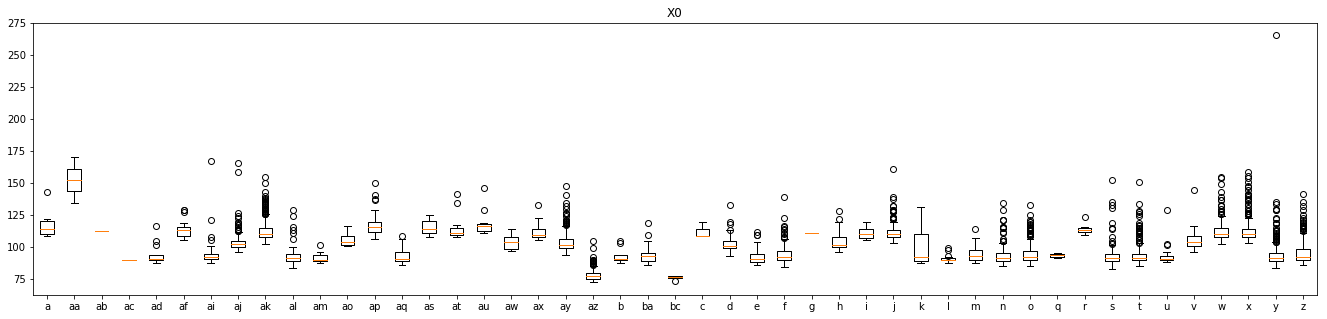

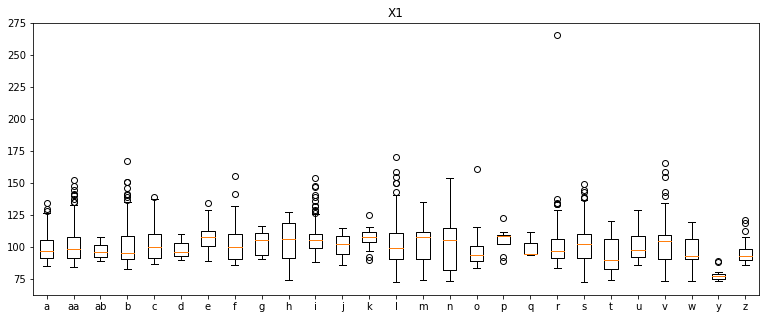

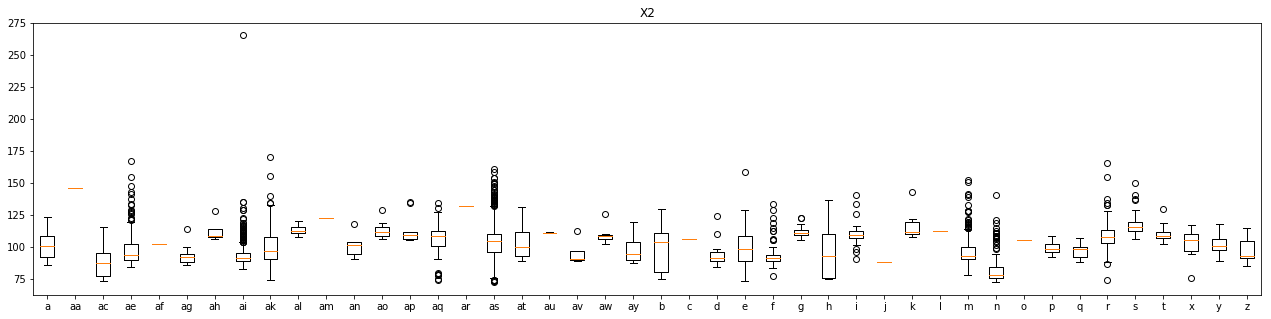

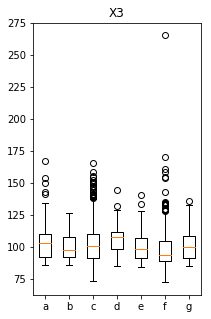

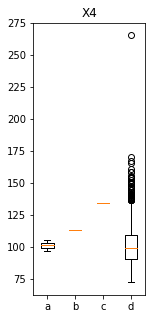

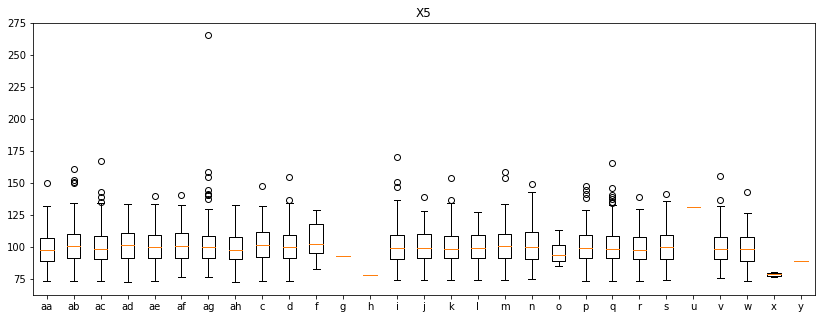

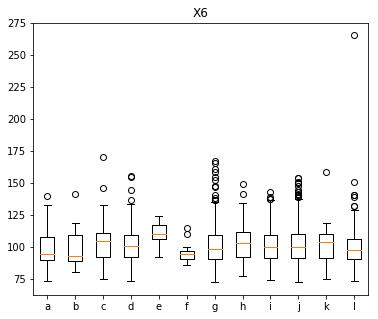

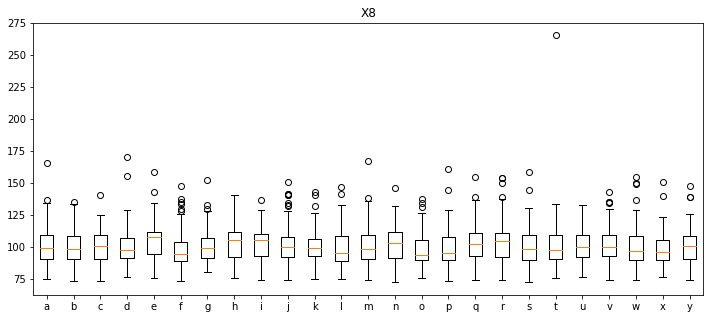

In [8]:
col_names = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8', ]
for c in col_names:
    d8 = df.groupby(c)['y'].apply(lambda x: x.tolist()).to_dict()
    fig = plt.figure(figsize = (len(d8)//2,5))
    ax = plt.axes()
    data = []
    labl = []
    for f in d8:
        data.append(d8[f])
        labl.append(f)
    # first boxplot pair
    bp = plt.boxplot(data)
    ax.set_xticklabels(labl)
    plt.title(c)
    plt.show()

Especially X0 and X2 have a significant impact on y. The others not so much. We keep that in mind. 


Adjust test and training data
====

Create Dummies for categorical vars in training data:

In [32]:
df_dummy = pd.get_dummies(df, prefix = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'])

id_train = df.ID
y = df.y
df_dummy = df_dummy.drop(['ID', 'y'],axis = 1)

X = np.array(df_dummy.as_matrix())

Read test data, and drop the unnecessary features. 

In [10]:
df_test = pd.read_csv("test.csv")
for f in dropped_features:
    df_test = df_test.drop(f, axis = 1)
    
id_test = np.array(df_test['ID'].tolist())
df_test = df_test.drop('ID',axis = 1)

df_test_dummy = pd.get_dummies(df_test, prefix = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'])

We can see that training and test set don't have all features in common:

In [11]:
D = set(df_test_dummy.columns) - set(df_dummy.columns)
print(D)

{'X5_a', 'X0_ag', 'X5_z', 'X2_ad', 'X5_t', 'X5_b', 'X2_aj', 'X2_u', 'X0_bb', 'X2_w', 'X2_ax', 'X2_ab', 'X0_av', 'X0_ae', 'X0_p', 'X0_an'}


Especially those features that are contained in the test set and are missing in the training set are a problem. How to deal with them? Fortunately, most of these features are rare:

In [12]:
print(df_test_dummy.loc[:, list(D)].sum())  # etc rotate through everything;

X5_a     1
X0_ag    1
X5_z     1
X2_ad    4
X5_t     1
X5_b     1
X2_aj    1
X2_u     1
X0_bb    1
X2_w     3
X2_ax    1
X2_ab    4
X0_av    1
X0_ae    1
X0_p     1
X0_an    1
dtype: int64


These features need to be replaces by some feature known to the training set. Right now I can't think of a clever way, so I'll replace them by the most common feature per group.

In [13]:
L0 = set(df_test['X0']) - set(df['X0'].tolist()) 
L2 = set(df_test['X2']) - set(df['X2'].tolist()) 
L5 = set(df_test['X5']) - set(df['X5'].tolist()) 

df_test.loc[df_test['X0'].isin(L0),'X0'] = df_test['X0'].value_counts().index[0]
df_test.loc[df_test['X2'].isin(L2),'X2'] = df_test['X2'].value_counts().index[0]
df_test.loc[df_test['X5'].isin(L5),'X5'] = df_test['X5'].value_counts().index[0]

df_test_dummy = pd.get_dummies(df_test, prefix = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'])

print('no unknown features any more:')
print( set(df_test_dummy.columns) - set(df_dummy.columns))

no unknown features any more:
set()


Further, drop useless columns from training data:

In [14]:
unused_cols = set(df_dummy.columns) - set(df_test_dummy.columns)
df_dummy = df_dummy.drop(unused_cols, axis = 1)

print('feature space is the same now:')
print(set(df_dummy.columns) == set(df_test_dummy.columns))

X = np.array(df_dummy.as_matrix())

feature space is the same now:
True


$(X,y)$ is now our training data, and X_test the corresponding test data.

In [15]:
X_test = np.array(df_test_dummy.as_matrix())

Grid Search
=====



In [16]:
cv_params = {'max_depth': [1,2,3,5,7,10,15,20]}
fix_params = {'learning_rate': 0.2, 'n_estimators': 100}

In [ ]:
csv = GridSearchCV(xgb.XGBRegressor(**fix_params), cv_params, scoring = 'r2', cv = 10)
csv.fit(X, y)
csv.best_params_

In [30]:
csv.grid_scores_

/home/dominik/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.56790, std: 0.08807, params: {'max_depth': 1},
 mean: 0.57360, std: 0.08881, params: {'max_depth': 2},
 mean: 0.56773, std: 0.09061, params: {'max_depth': 3},
 mean: 0.55113, std: 0.09756, params: {'max_depth': 5},
 mean: 0.53929, std: 0.08904, params: {'max_depth': 7},
 mean: 0.52381, std: 0.08308, params: {'max_depth': 10},
 mean: 0.49307, std: 0.07057, params: {'max_depth': 15},
 mean: 0.48466, std: 0.07122, params: {'max_depth': 20}]

In [17]:
cv_params = {'min_child_weight': [7,8,9,10,11,12,13]}
fix_params['max_depth'] = 2

In [ ]:
csv = GridSearchCV(xgb.XGBRegressor(**fix_params), cv_params, scoring = 'r2', cv = 10)
csv.fit(X, y)
print(csv.best_params_)

In [36]:
csv.grid_scores_

/home/dominik/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.57537, std: 0.08780, params: {'min_child_weight': 7},
 mean: 0.57509, std: 0.08834, params: {'min_child_weight': 8},
 mean: 0.57545, std: 0.08856, params: {'min_child_weight': 9},
 mean: 0.57569, std: 0.08898, params: {'min_child_weight': 10},
 mean: 0.57600, std: 0.08998, params: {'min_child_weight': 11},
 mean: 0.57542, std: 0.08860, params: {'min_child_weight': 12},
 mean: 0.57515, std: 0.08955, params: {'min_child_weight': 13}]

In [18]:
cv_params = {'subsample': [0.5, 0.6, 0.7,0.8,0.9,1]}
fix_params['min_child_weight'] = 11

In [ ]:
csv = GridSearchCV(xgb.XGBRegressor(**fix_params), cv_params, scoring = 'r2', cv = 10)
csv.fit(X, y)
print(csv.best_params_)

In [38]:
csv.grid_scores_

/home/dominik/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.56697, std: 0.09138, params: {'subsample': 0.5},
 mean: 0.57030, std: 0.08899, params: {'subsample': 0.6},
 mean: 0.57094, std: 0.08860, params: {'subsample': 0.7},
 mean: 0.57549, std: 0.08991, params: {'subsample': 0.8},
 mean: 0.57433, std: 0.08921, params: {'subsample': 0.9},
 mean: 0.57600, std: 0.08998, params: {'subsample': 1}]

In [19]:
cv_params = {'max_delta_step': [7,8,9,10,11,12,15,20]}
fix_params['subsample'] = 1

In [42]:
csv = GridSearchCV(xgb.XGBRegressor(**fix_params), cv_params, scoring = 'r2', cv = 10)
csv.fit(X, y)
print(csv.best_params_)

/home/dominik/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.57947, std: 0.08994, params: {'max_delta_step': 7},
 mean: 0.57951, std: 0.09010, params: {'max_delta_step': 8},
 mean: 0.57924, std: 0.08994, params: {'max_delta_step': 9},
 mean: 0.57915, std: 0.08914, params: {'max_delta_step': 10},
 mean: 0.57857, std: 0.08930, params: {'max_delta_step': 11},
 mean: 0.57835, std: 0.08994, params: {'max_delta_step': 12},
 mean: 0.57675, std: 0.08922, params: {'max_delta_step': 15},
 mean: 0.57564, std: 0.08852, params: {'max_delta_step': 20}]

In [ ]:
csv.grid_scores_

In [20]:
cv_params = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}
fix_params['max_delta_step'] = 8

In [ ]:
csv = GridSearchCV(xgb.XGBRegressor(**fix_params), cv_params, scoring = 'r2', cv = 10)
csv.fit(X, y)
print(csv.best_params_)

In [44]:
csv.grid_scores_

/home/dominik/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -23.22781, std: 2.97068, params: {'learning_rate': 0.05},
 mean: -2.59069, std: 0.23806, params: {'learning_rate': 0.1},
 mean: 0.57703, std: 0.09302, params: {'learning_rate': 0.15},
 mean: 0.57951, std: 0.09010, params: {'learning_rate': 0.2},
 mean: 0.57732, std: 0.08840, params: {'learning_rate': 0.25},
 mean: 0.57745, std: 0.09017, params: {'learning_rate': 0.3}]

In [21]:
fix_params['learning_rate'] = 0.2

In [22]:
fix_params

{'learning_rate': 0.2,
 'max_delta_step': 8,
 'max_depth': 2,
 'min_child_weight': 11,
 'n_estimators': 100,
 'subsample': 1}

In [47]:
del fix_params['max_depth']

In [49]:
cv_params = {'max_depth': [1,2,3,4, 5,7,10,15,20]}
#cv_params = {'min_child_weight', 'subsample': [0.8,0.9,1], 'max_delta_step': [0,1,2,4], 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

csv = GridSearchCV(xgb.XGBRegressor(**fix_params), cv_params, scoring = 'r2', cv = 10)
csv.fit(X, y)
print(csv.best_params_)

{'max_depth': 2}


Not much has changed any more.

In [23]:
fix_params['max_depth'] = 2

Confirm found parameters.

In [28]:
fix_params ={'learning_rate': 0.2,
 'max_delta_step': 8,
 'max_depth': 2,
 'min_child_weight': 11,
 'n_estimators': 100,
 'subsample': 1}

Make Predictions
====

In [27]:
xgdmat_train = xgb.DMatrix(X, y)
xgdmat_test = xgb.DMatrix(X_test)
xgb_final = xgb.train(fix_params, xgdmat_train, num_boost_round = 1000)
y_pred = xgb_final.predict(xgdmat_test)
df_out = pd.DataFrame({"ID":id_test, "y":y_pred})

df_out.to_csv("sol.csv", index= False)